# Zebrafish neural crest cells perturbation simulation

## Library imports

In [1]:
import tensorflow
import scvelo as scv
import scanpy as sc
import cellrank as cr
from anndata import AnnData
from typing import Iterable, List, Literal, Optional, Sequence, Tuple, Union,Collection
from tqdm import tqdm
import numpy as np
import pandas as pd
import random
from collections import Counter

from scvelo.preprocessing.moments import get_moments
from scvelo.plotting.simulation import compute_dynamics
from scipy.spatial.distance import cdist
from scipy.stats import wilcoxon
from scipy.stats import ranksums
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm, rcParams
from matplotlib.colors import ListedColormap
import mplscience

from sklearn.metrics import roc_auc_score
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
import scipy
from scipy.stats import ranksums

import torch
import torch.nn.functional as F
import regvelovi
from regvelovi import REGVELOVI
from velovi import preprocess_data, VELOVI
import anndata
from scipy.stats import wilcoxon

from itertools import chain, product
from typing import Dict, Optional
from sklearn.metrics import auc

import sys
import cellrank as cr
import os, shutil
sys.path.append("../..")
from paths import FIG_DIR, DATA_DIR

2024-08-30 05:40:24.944837: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-30 05:40:25.020720: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 05:40:25.762797: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/torchvision/image.so: undefined

## General settings

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map='viridis')

In [3]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / 'zebrafish' / 'perturbation' ,exist_ok = True)

SAVE_DATASETS = True
if SAVE_DATASETS:
    os.makedirs(DATA_DIR / 'zebrafish' / 'perturbation' ,exist_ok = True)

## Function defination

In [4]:
def get_var_ranks(
    # This code is based on an implementation by Philipp Weilier from his repository:
    # https://github.com/theislab/cellrank2_reproducibility
    # Original function: get_var_ranks() in https://github.com/theislab/cellrank2_reproducibility/blob/main/notebooks/labeling_kernel/method_comparison.ipynb
    # License: BSD-3-Clause license

    var_names: List[str], drivers: pd.DataFrame, macrostate: str, var_type: str, model: str, threshold: int = 100
):
    """Get ranking of a set of variables towards a given macrostate."""
    _df = drivers.loc[
        var_names, [f"{macrostate}_corr", f"{macrostate}_pval", f"Corr. rank - {macrostate}"]
    ].sort_values(by=[f"Corr. rank - {macrostate}"])

    _df["Type"] = var_type
    _df["Algorithm"] = model

    print(
        f"{var_type} towards {macrostate} for {model} in top {threshold}: "
        f"{(_df[f'Corr. rank - {macrostate}'] <= threshold).sum()} (out of {_df.shape[0]})"
    )

    return _df

def add_regvelo_outputs_to_adata(adata_raw, vae):
    # This code is adapted on an implementation by Adam Gayoso, Philipp Weilier and Justing Hong from their repository:
    # https://github.com/YosefLab/velovi_reproducibility
    # Original function: fit_velovi() in https://github.com/YosefLab/velovi_reproducibility/blob/main/notebooks/estimation_comparison/model_fit.ipynb
    # License: BSD-3-Clause license

    latent_time = vae.get_latent_time(n_samples=30, time_statistic = "mean",batch_size = adata_raw.shape[0])
    velocities = vae.get_velocity(n_samples=30, velo_statistic="mean",batch_size = adata_raw.shape[0])

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:,vae.module.target_index].copy()
    
    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_regvelo"] = latent_time
    
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    
    return adata

def add_outputs_to_adata(adata, vae):
    # This code is adapted on an implementation by Adam Gayoso, Philipp Weilier and Justing Hong from their repository:
    # https://github.com/YosefLab/velovi_reproducibility
    # Original function: fit_velovi() in https://github.com/YosefLab/velovi_reproducibility/blob/main/notebooks/estimation_comparison/model_fit.ipynb
    # License: BSD-3-Clause license
    
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    
def cal_cell_fate(adata_target,terminal_states,n_states = 7):
    terminal_id = terminal_states.copy()
    terminal_type = terminal_states.copy()
    for i in terminal_states:
        for j in [1,2,3,4,5,6,7,8,9,10]:
            terminal_id.append(i+"_"+str(j))
            terminal_type.append(i)
    terminal_dict = dict(zip(terminal_id, terminal_type))
    
    vk = cr.kernels.VelocityKernel(adata_target).compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata_target).compute_transition_matrix()
    combined_kernel = 0.8 * vk + 0.2 * ck
    #ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
    g2 = cr.estimators.GPCCA(combined_kernel)
    ## evaluate the fate prob on original space
    g2.compute_macrostates(n_states=n_states, n_cells = 10,cluster_key="cell_type")
    ## set a high number of states, and merge some of them and rename
    terminal_states_perturb = g2.macrostates.cat.categories.tolist()
    terminal_states_perturb = list(set(terminal_states_perturb).intersection(terminal_id))
    subset_dict = {key: terminal_dict[key] for key in terminal_states_perturb}
    terminal_states_perturb_names = list(subset_dict.values())
    ## check if all terminal state is coverred
    if len(set(terminal_states_perturb_names).intersection(terminal_states)) != len(terminal_states):
        ValueError("Terminal states are not recoverred in perturbation, please increase the number of the states!")
    g2.set_terminal_states(
        terminal_states_perturb
    )
    g2.compute_fate_probabilities(solver="direct")
    fb = g2.fate_probabilities
    sampleID = adata.obs.index.tolist()
    fate_name = fb.names.tolist()
    fb = pd.DataFrame(fb,index= sampleID,columns=fate_name)
    fate_prob2 = pd.DataFrame(columns= terminal_states, index=sampleID)    
    for i in terminal_states:
        fate_prob2.loc[:,i] = fb.loc[:,[j == i for j in terminal_states_perturb_names]].sum(1).tolist()
        
    return fate_prob2

def _in_silico_block_regulation_simulation(model,adata, regulator, target,effects = 0):
    reg_vae_perturb = REGVELOVI.load(model,adata)
    perturb_GRN = reg_vae_perturb.module.v_encoder.fc1.weight.detach().clone()
    
    """
    if regulation_block:
        perturb_GRN[(perturb_GRN[:,[i == gene for i in adata.var.index]].abs()>1e-3).cpu().numpy().reshape(-1),[i == gene for i in adata.var.index]] = 0
    if target_block:
        perturb_GRN[[i == gene for i in adata_target.var.index],(perturb_GRN[[i == gene for i in adata_target.var.index],:].abs()>1e-3).cpu().numpy().reshape(-1)] = 0
    """
    perturb_GRN[[i == target for i in adata_target.var.index],[i == regulator for i in adata_target.var.index]] = effects
    
    reg_vae_perturb.module.v_encoder.fc1.weight.data = perturb_GRN
    adata_target_perturb = add_regvelo_outputs_to_adata(adata, reg_vae_perturb)
    
    return adata_target_perturb

def _in_silico_block_simulation(model,adata, gene,regulation_block = True, target_block = True,effects = 0,cutoff = 0):
    reg_vae_perturb = REGVELOVI.load(model,adata)
    perturb_GRN = reg_vae_perturb.module.v_encoder.fc1.weight.detach().clone()
    
    if regulation_block:
        perturb_GRN[(perturb_GRN[:,[i == gene for i in adata.var.index]].abs()>cutoff).cpu().numpy().reshape(-1),[i == gene for i in adata.var.index]] = effects
    if target_block:
        perturb_GRN[[i == gene for i in adata_target.var.index],(perturb_GRN[[i == gene for i in adata_target.var.index],:].abs()>1e-3).cpu().numpy().reshape(-1)] = effects
    
    reg_vae_perturb.module.v_encoder.fc1.weight.data = perturb_GRN
    adata_target_perturb = add_regvelo_outputs_to_adata(adata, reg_vae_perturb)
    
    return adata_target_perturb,reg_vae_perturb

In [5]:
def DEG(gene_expression, cell_labels):
    # Create a dataframe from the gene expression array and cell labels
    df = pd.DataFrame(gene_expression)
    df['cell_type'] = cell_labels
    
    # Get the list of unique cell types
    cell_types = np.unique(cell_labels)
    genes = df.columns[:-1]
    
    # Initialize lists to store results
    results = []
    
    for cell_type in cell_types:
        # Get the expression data for the current cell type and the others
        current_group = df[df['cell_type'] == cell_type].drop(columns=['cell_type'])
        other_group = df[df['cell_type'] != cell_type].drop(columns=['cell_type'])
        
        for gene in genes:
            # Calculate mean expression
            mean_current = current_group[gene].mean()
            mean_others = other_group[gene].mean()
            
            # Avoid division by zero and log2 of zero
            if mean_others == 0:
                mean_others = np.finfo(float).eps
            
            # Calculate log2 fold change
            log2_fold_change = np.log2(mean_current / mean_others)
            
            # Perform Wilcoxon rank-sum test
            stat, p_value = ranksums(current_group[gene], other_group[gene])
            
            # Append results
            results.append({
                'gene': gene,
                'cell_type': cell_type,
                'log2FC': log2_fold_change,
                'p_value': p_value
            })
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

In [6]:
def prior_GRN(adata, gt_net):
    ## filter low co-expressed GRN
    regulator_index = [i in gt_net.columns for i in adata.var.index.values]
    target_index = [i in gt_net.index for i in adata.var.index.values]
    
    corr_m = 1 - cdist(adata.X.todense().T, adata.X.todense().T, metric='correlation')
    corr_m = torch.tensor(corr_m)
    corr_m = corr_m[target_index,]
    corr_m = corr_m[:,regulator_index]
    corr_m = corr_m.float()

    corr_m[np.isnan(corr_m)] = 0
    corr_m = pd.DataFrame(corr_m, index = adata.var.index.values[target_index], columns = adata.var.index.values[regulator_index])
    gt_net = gt_net.loc[corr_m.index,corr_m.columns]
    GRN_final = gt_net * corr_m

    GRN_final[abs(GRN_final)<0.01] = 0
    GRN_final[GRN_final!=0] = 1
    for i in GRN_final.columns:
        GRN_final.loc[i,i] = 0
    GRN_final = GRN_final.iloc[(GRN_final.sum(1) > 0).tolist(),(GRN_final.sum(0) > 0).tolist()]
    genes = np.unique(GRN_final.index.tolist()+GRN_final.columns.tolist())
    W = torch.zeros((len(genes),len(genes)))
    W = pd.DataFrame(W,index = genes,columns = genes)
    W.loc[GRN_final.columns.tolist(),GRN_final.index.tolist()] = GRN_final.T
    
    reg_bdata = adata[:,W.index].copy()

    W = W.loc[reg_bdata.var.index.values.tolist(),reg_bdata.var.index.values.tolist()]
    W = torch.tensor(np.array(W))
    reg_bdata.uns["regulators"] = reg_bdata.var.index.values
    reg_bdata.uns["targets"] = reg_bdata.var.index.values
    intersection = list(set(reg_bdata.uns["regulators"]).intersection(reg_bdata.uns["targets"]))

    reg_bdata.uns["regulators"] = reg_bdata.var.index.values
    reg_bdata.uns["targets"] = reg_bdata.var.index.values
    reg_bdata.uns["skeleton"] = np.array(W)
    reg_bdata.uns["network"] = np.ones((len(reg_bdata.var.index),len(reg_bdata.var.index)))

    return reg_bdata

In [7]:
def get_significance(pvalue) -> str:
    # This code is adapted on an implementation by Adam Gayoso, Philipp Weilier and Justing Hong from their repository:
    # https://github.com/YosefLab/velovi_reproducibility
    # Original function: get_significance() in https://github.com/YosefLab/velovi_reproducibility/blob/main/notebooks/estimation_comparison/fucci.ipynb
    # License: BSD-3-Clause license
    
    """Assign significance symbol based on p-value."""
    if pvalue < 0.001:
        return "***"
    elif pvalue < 0.01:
        return "**"
    elif pvalue < 0.1:
        return "*"
    else:
        return "n.s."

In [8]:
def threshold_top_k(tensor, k):
    # Flatten the tensor
    flattened_tensor = tensor.flatten()

    # Get the indices of the top k positive and negative values
    _, top_k_pos_indices = torch.topk(flattened_tensor, k)
    _, top_k_neg_indices = torch.topk(-flattened_tensor, k)

    # Create a mask for the top k positive and negative values
    mask = torch.zeros_like(flattened_tensor, dtype=torch.float)
    mask[top_k_pos_indices] = 1
    mask[top_k_neg_indices] = 1

    # Reshape the mask to the original tensor shape
    mask = mask.view(tensor.shape)

    return mask

def p_adjust_bh(p):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]

def abundance_test(prob_raw, prob_pert, correction = True):
    y = [0] * prob_raw.shape[0] + [1] * prob_pert.shape[0]
    X = pd.concat([prob_raw,prob_pert],0)
    
    table = []
    for i in range(prob_raw.shape[1]):
        pred = X.iloc[:,i]
        var = X.iloc[:,[j != i for j in range(prob_raw.shape[1])]]
        #var = sm.add_constant(var)
        est = sm.OLS(pred, var)
        est2 = est.fit()
        #pred = pred - est2.predict(var)
        #pred = pred - est2.predict(var)
        #pred = scipy.stats.zscore(pred)
        #pred = np.log(pred * 100 + 0.01)
        table.append(np.expand_dims(np.array(list(scipy.stats.spearmanr(pred,y))),0))
    
    table = np.concatenate(table,0)
    table = pd.DataFrame(table)
    table.index = prob_raw.columns
    table.columns = ["coefficient","p-value"]
    ## Running FDR addjust
    table.loc[:,"FDR adjusted p-value"] = p_adjust_bh(table.loc[:,"p-value"].tolist())
    
    return table

def get_list_name(lst):
    names = []
    for name, obj in lst.items():
        names.append(name)
    return names

def has_zero_column_sum(matrix):
    # Check if any column sum is zero
    column_sums = matrix.sum(axis=0)
    return np.any(column_sums == 0)
    
from scvelo import logging as logg
## TODO: if calculation has error, increase the number of macrostates
## if can't fully recover all state, increase the number of macrostates
def TFScanning(model_path, adata, n_states, cluster_label, terminal_states, TF, effect):
    reg_vae = REGVELOVI.load(model_path, adata)
    #reg_vae.module = reg_vae.module.cpu()
    adata = add_regvelo_outputs_to_adata(adata, reg_vae)
    raw_GRN = reg_vae.module.v_encoder.fc1.weight.detach().clone()
    perturb_GRN = reg_vae.module.v_encoder.fc1.weight.detach().clone()
    ## curated all targets of specific TF
    weight = raw_GRN.sum(0)
    #TF = adata.var.index[weight != 0].tolist()
    vk = cr.kernels.VelocityKernel(adata)
    vk.compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
    combined_kernel = 0.8 * vk + 0.2 * ck
    g2 = cr.estimators.GPCCA(combined_kernel)
    ## evaluate the fate prob on original space
    
    g2.compute_macrostates(n_states=n_states, n_cells = 30, cluster_key=cluster_label)
    # set a high number of states, and merge some of them and rename
    if terminal_states is None:
        g2.predict_terminal_states()
        terminal_states = g2.terminal_states.cat.categories.tolist()
    g2.set_terminal_states(
        terminal_states
    )        
    #g2 = g2.rename_terminal_states({"Mono_1": "Mono","DCs_1":"DC"})
    g2.compute_fate_probabilities(solver="direct")
    fate_prob = g2.fate_probabilities
    sampleID = adata.obs.index.tolist()
    fate_name = fate_prob.names.tolist()
    fate_prob = pd.DataFrame(fate_prob,index= sampleID,columns=fate_name)
    fate_prob_original = fate_prob.copy()
    ## create dictionary
    terminal_id = terminal_states.copy()
    terminal_type = terminal_states.copy()
    for i in terminal_states:
        for j in [1,2,3,4,5,6,7,8,9,10]:
            terminal_id.append(i+"_"+str(j))
            terminal_type.append(i)
    terminal_dict = dict(zip(terminal_id, terminal_type))
    n_states = len(g2.macrostates.cat.categories.tolist())
    coef = []
    pvalue = []
    for tf in TF:
        perturb_GRN = raw_GRN.clone()
        #perturb_GRN[:,[i in tf for i in adata.var.index.tolist()]] = 0
        vec = perturb_GRN[:,[i in tf for i in adata.var.index.tolist()]].clone()
        vec[vec.abs() > 1e-3] = 0
        perturb_GRN[:,[i in tf for i in adata.var.index.tolist()]]= vec
        reg_vae_perturb = REGVELOVI.load(model_path, adata)
        reg_vae_perturb.module.v_encoder.fc1.weight.data = perturb_GRN
            
        adata_target = add_regvelo_outputs_to_adata(adata, reg_vae_perturb)
        ## perturb the regulations
        vk = cr.kernels.VelocityKernel(adata_target)
        vk.compute_transition_matrix()
        ck = cr.kernels.ConnectivityKernel(adata_target).compute_transition_matrix()
        combined_kernel = 0.8 * vk + 0.2 * ck
        g2 = cr.estimators.GPCCA(combined_kernel)
        ## evaluate the fate prob on original space
        n_states_perturb = n_states
        while True:
            try:
                # Perform some computation in f(a)
                g2.compute_macrostates(n_states=n_states_perturb, n_cells = 30, cluster_key=cluster_label)
                # If no error is raised, break the loop and return the result
                #g2.set_terminal_states(
                #    terminal_states
                #)
                break
            except:
                # If an error is raised, increment a and try again, and need to recompute double knock-out reults
                n_states_perturb += 1
                vk = cr.kernels.VelocityKernel(adata)
                vk.compute_transition_matrix()
                ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
                g = cr.estimators.GPCCA(0.8*vk+0.2*ck)
                ## evaluate the fate prob on original space
                g.compute_macrostates(n_states=n_states_perturb, n_cells = 30,cluster_key=cluster_label)
                ## set a high number of states, and merge some of them and rename
                if terminal_states is None:
                    g.predict_terminal_states()
                    terminal_states = g.terminal_states.cat.categories.tolist()
                g.set_terminal_states(
                    terminal_states
                )
                #g2 = g2.rename_terminal_states({"Mono_1": "Mono","DCs_1":"DC"})
                g.compute_fate_probabilities(solver="direct")
                fate_prob = g.fate_probabilities
                sampleID = adata.obs.index.tolist()
                fate_name = fate_prob.names.tolist()
                fate_prob = pd.DataFrame(fate_prob,index= sampleID,columns=fate_name)
                
        ## intersection the states
        terminal_states_perturb = g2.macrostates.cat.categories.tolist()
        #terminal_states_perturb = list(set(terminal_states_perturb).intersection(terminal_id))
        terminal_states_perturb = list(set(terminal_states_perturb).intersection(terminal_states))
        
        g2.set_terminal_states(
            terminal_states_perturb
        )
        g2.compute_fate_probabilities(solver="direct")
        fb = g2.fate_probabilities
        sampleID = adata.obs.index.tolist()
        fate_name = fb.names.tolist()
        fb = pd.DataFrame(fb,index= sampleID,columns=fate_name)
        fate_prob2 = pd.DataFrame(columns= terminal_states, index=sampleID)   
        
        for i in terminal_states_perturb:
            #fate_prob2.loc[:,i] = fb.loc[:,[j == i for j in terminal_states_perturb_names]].sum(1).tolist()
            fate_prob2.loc[:,i] = fb.loc[:,i]

        fate_prob2 = fate_prob2.fillna(0)
        arr = np.array(fate_prob2.sum(0))
        arr[arr!=0] = 1
        fate_prob = fate_prob * arr
        
        y = [0] * fate_prob.shape[0] + [1] * fate_prob2.shape[0]
        fate_prob2.index = [i + "_perturb" for i in fate_prob2.index]
        test_result = abundance_test(fate_prob, fate_prob2)
        coef.append(test_result.loc[:, "coefficient"])
        pvalue.append(test_result.loc[:, "FDR adjusted p-value"]) 
        logg.info("Done "+tf)
        fate_prob = fate_prob_original.copy()
    d = {'TF': TF, 'coefficient': coef, 'pvalue': pvalue}
    #df = pd.DataFrame(data=d)      
    return d

In [9]:
def split_elements(character_list):
    result_list = []
    for element in character_list:
        if '_' in element:
            parts = element.split('_')
            result_list.append(parts)
        else:
            result_list.append([element])
    return result_list

def combine_elements(split_list):
    result_list = []
    for parts in split_list:
        combined_element = "_".join(parts)
        result_list.append(combined_element)
    return result_list


def Multiple_TFScanning(model_path, adata, n_states, cluster_label, terminal_states, TF_pair, effect):
    reg_vae = REGVELOVI.load(model_path, adata)
    #reg_vae.module = reg_vae.module.cpu()
    adata = add_regvelo_outputs_to_adata(adata, reg_vae)
    raw_GRN = reg_vae.module.v_encoder.fc1.weight.detach().clone()
    perturb_GRN = reg_vae.module.v_encoder.fc1.weight.detach().clone()
    ## curated all targets of specific TF
    weight = raw_GRN.sum(0)
    #TF = adata.var.index[weight != 0].tolist()
    vk = cr.kernels.VelocityKernel(adata)
    vk.compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
    g2 = cr.estimators.GPCCA(0.8*vk+0.2*ck)
    ## evaluate the fate prob on original space
    g2.compute_macrostates(n_states=n_states, n_cells = 30,cluster_key=cluster_label)
    ## set a high number of states, and merge some of them and rename
    if terminal_states is None:
        g2.predict_terminal_states()
        terminal_states = g2.terminal_states.cat.categories.tolist()
    g2.set_terminal_states(
        terminal_states
    )
    #g2 = g2.rename_terminal_states({"Mono_1": "Mono","DCs_1":"DC"})
    g2.compute_fate_probabilities(solver="direct")
    fate_prob = g2.fate_probabilities
    sampleID = adata.obs.index.tolist()
    fate_name = fate_prob.names.tolist()
    fate_prob = pd.DataFrame(fate_prob,index= sampleID,columns=fate_name)
    ## create dictionary
    terminal_id = terminal_states.copy()
    terminal_type = terminal_states.copy()
    for i in terminal_states:
        for j in [1,2,3,4,5,6,7,8,9,10]:
            terminal_id.append(i+"_"+str(j))
            terminal_type.append(i)
    terminal_dict = dict(zip(terminal_id, terminal_type))
    coef = []
    pvalue = []
    for tf_pair in TF_pair:
        perturb_GRN = raw_GRN.clone()
        #perturb_GRN[:,[i in tf for i in adata.var.index.tolist()]] = 0
        vec = perturb_GRN[:,[i in tf_pair for i in adata.var.index.tolist()]].clone()
        vec[vec.abs() > 0] = 1
        perturb_GRN[:,[i in tf_pair for i in adata.var.index.tolist()]]= -1 * effect * vec
        reg_vae_perturb = REGVELOVI.load(model_path, adata)
        reg_vae_perturb.module.v_encoder.fc1.weight.data = perturb_GRN
        adata_target = add_regvelo_outputs_to_adata(adata, reg_vae_perturb)
        ## perturb the regulations
        vk = cr.kernels.VelocityKernel(adata_target)
        vk.compute_transition_matrix()
        ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
        g2 = cr.estimators.GPCCA(0.8*vk+0.2*ck)
        ## evaluate the fate prob on original space
        g2.compute_macrostates(n_states=n_states, n_cells = 30, cluster_key=cluster_label)
        ## intersection the states
        terminal_states_perturb = g2.macrostates.cat.categories.tolist()
        terminal_states_perturb = list(set(terminal_states_perturb).intersection(terminal_id))
        subset_dict = {key: terminal_dict[key] for key in terminal_states_perturb}
        terminal_states_perturb_names = list(subset_dict.values())
        ## check if all terminal state is coverred
        if len(set(terminal_states_perturb_names).intersection(terminal_states)) != len(terminal_states):
            ValueError("Terminal states are not recoverred in perturbation, please increase the number of the states!")
        g2.set_terminal_states(
            terminal_states_perturb
        )
        g2.compute_fate_probabilities(solver="direct")
        fb = g2.fate_probabilities
        sampleID = adata.obs.index.tolist()
        fate_name = fb.names.tolist()
        fb = pd.DataFrame(fb,index= sampleID,columns=fate_name)
        fate_prob2 = pd.DataFrame(columns= terminal_states, index=sampleID)   
        for i in terminal_states:
            fate_prob2.loc[:,i] = fb.loc[:,[j == i for j in terminal_states_perturb_names]].sum(1).tolist()
        y = [0] * fate_prob.shape[0] + [1] * fate_prob2.shape[0]
        fate_prob2.index = [i + "_perturb" for i in fate_prob2.index]
        test_result = abundance_test(fate_prob, fate_prob2)
        coef.append(test_result.loc[:, "coefficient"])
        pvalue.append(test_result.loc[:, "FDR adjusted p-value"]) 
        print(tf_pair)
        logg.info("Done "+combine_elements([tf_pair])[0])
    d = {'TF': combine_elements(TF_pair), 'coefficient': coef, 'pvalue': pvalue}
    #df = pd.DataFrame(data=d)      
    return d

In [10]:
def bar_scores(test_result,adata,color_label,gene_name, figsize=(4, 3),min = 0, max = 1,loc = 0.8):
    # This code is adapted on an implementation by Adam Gayoso, Philipp Weilier and Justing Hong from their repository:
    # https://github.com/YosefLab/velovi_reproducibility
    # Original function: plot_perm_scores() in https://github.com/YosefLab/velovi_reproducibility/blob/main/notebooks/permutation_score/pancreas.ipynb
    # License: BSD-3-Clause license

    df = pd.DataFrame(test_result.loc[:,"coefficient"])
    df["Cell type"] = test_result.index
    df["pvalue"] = test_result["pvalue"]
    def significance_stars(p):
        if p < 0.001:
            return '***'
        elif p < 0.01:
            return '**'
        elif p < 0.05:
            return '*'
        else:
            return ''
    
    # Add a column for stars
    df['stars'] = df['pvalue'].apply(significance_stars)
    order = test_result.index.tolist()
    
    palette = dict(zip(adata.obs[color_label].cat.categories, adata.uns[f"{color_label}_colors"]))
    subset_palette = {name: color for name, color in palette.items() if name in test_result.index.tolist()}
    
    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=figsize)
        sns.barplot(
            data=df,
            x="coefficient",
            y="Cell type",
            palette=subset_palette,
            order=order,
            ax=ax,
            
        )
        for i in test_result.index.tolist():
            p_val = test_result.loc[i,"pvalue"]
            if p_val < 0.001:
                level = '***'
            elif p_val < 0.01:
                level = '**'
            elif p_val < 0.05:
                level = '*'
            elif p_val < 1:
                level = 'ns'
            
            plt.text(loc, test_result.index.tolist().index(i), level, ha='center', va='center', color='red',fontsize=14)

        #ax.set(ylim=(-2.1,2.1))
        ax.tick_params(axis='x', rotation=90)
        plt.xlim(min,max) 
        plt.title("$\mathit{" + gene_name + "}$ correlation with cell fate")

## Load dataset

In [11]:
adata = sc.read_h5ad(DATA_DIR / "zebrafish" / "zebrafish_analysis.h5ad")

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


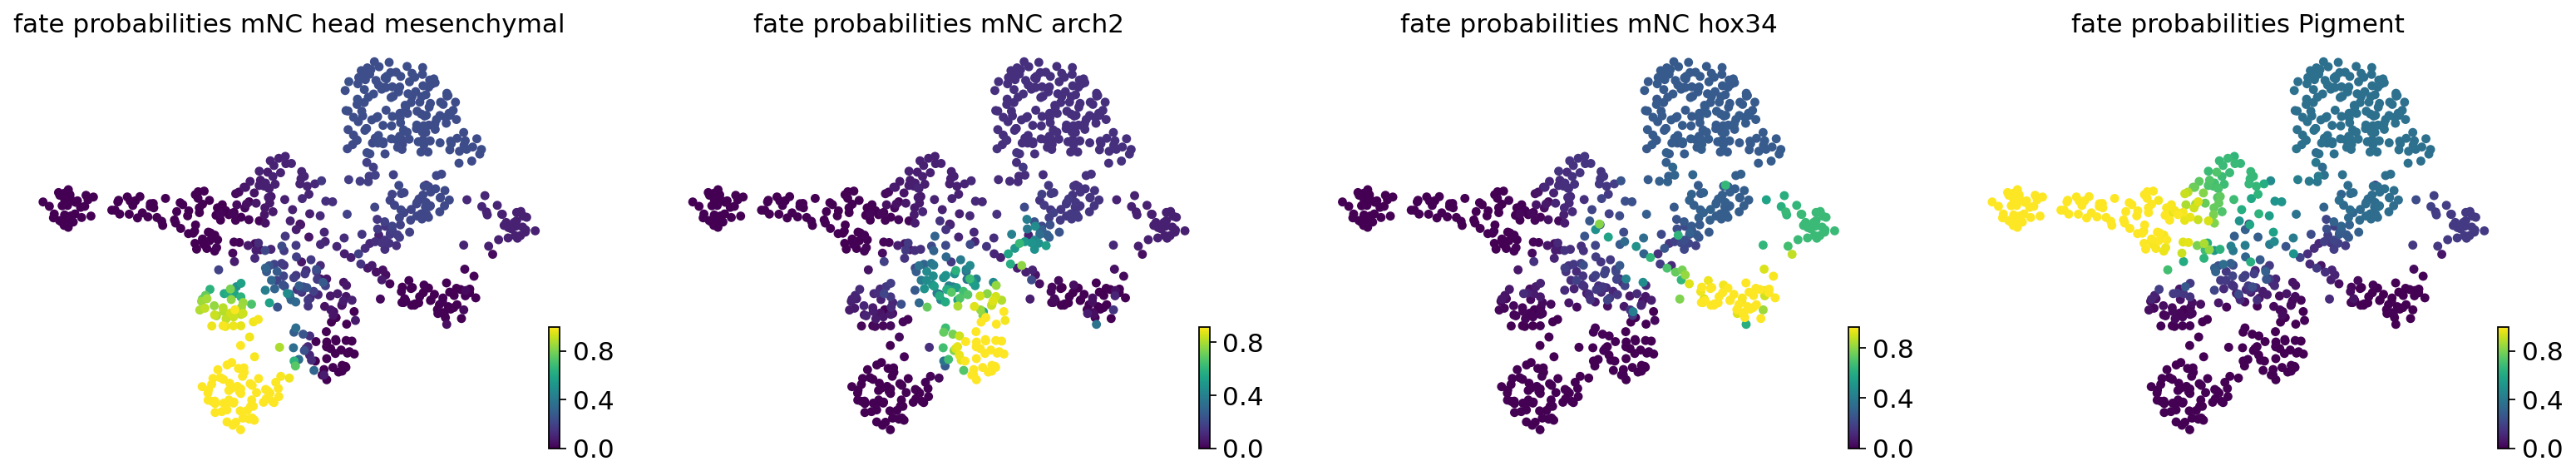

In [12]:
terminal_states = [
        "mNC_head_mesenchymal",
        "mNC_arch2",
        "mNC_hox34",
        "Pigment",
    ]
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
g_raw = cr.estimators.GPCCA(vk)
## evaluate the fate prob on original space
g_raw.compute_macrostates(n_states=8,cluster_key="cell_type")
g_raw.set_terminal_states(terminal_states)
g_raw.compute_fate_probabilities()
g_raw.plot_fate_probabilities(same_plot=False)

## Perform perturbation simulation

In [13]:
## Perform perturbation simulation
fate_prob_perturb = []
cand_list = ["nr2f5","sox9b","twist1a","twist1b","sox10","mitfa","tfec","tfap2a","tfap2b"]
for TF in cand_list:
    model = DATA_DIR / 'zebrafish' / 'rgv_model_0'
    adata_target_perturb,reg_vae_perturb =  _in_silico_block_simulation(model,adata,TF,target_block = False,effects = 0)
    ### predict the terminal state dfference
    n_states = 8
    vk = cr.kernels.VelocityKernel(adata_target_perturb)
    vk.compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata_target_perturb).compute_transition_matrix()
    g = cr.estimators.GPCCA(vk)
    ## evaluate the fate prob on original space
    g.compute_macrostates(n_states=n_states,cluster_key="cell_type")
    g.set_terminal_states(terminal_states)
    g.compute_fate_probabilities()
    ## visualize coefficient
    cond1_df = pd.DataFrame(adata_target_perturb.obsm["lineages_fwd"], columns=adata_target_perturb.obsm["lineages_fwd"].names.tolist())

    fate_prob_perturb.append(cond1_df)

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/4 [00:00<?, ?/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/4 [00:00<?, ?/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/4 [00:00<?, ?/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/4 [00:00<?, ?/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: 

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/4 [00:00<?, ?/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


In [14]:
cond2_df = pd.DataFrame(adata.obsm["lineages_fwd"], columns=adata.obsm["lineages_fwd"].names.tolist())
df_list = []
for i in range(len(fate_prob_perturb)):
    #data = np.array(((fate_prob_perturb[i]+1) - (cond2_df+1)))
    data = abundance_test(cond2_df, fate_prob_perturb[i])
    data = pd.DataFrame({"Score": data.iloc[:,0].tolist(),
                     "Terminal state": data.index.tolist(),
                     "TF":[cand_list[i]]*(data.shape[0])})
    df_list.append(data)

In [15]:
df = pd.concat(df_list)

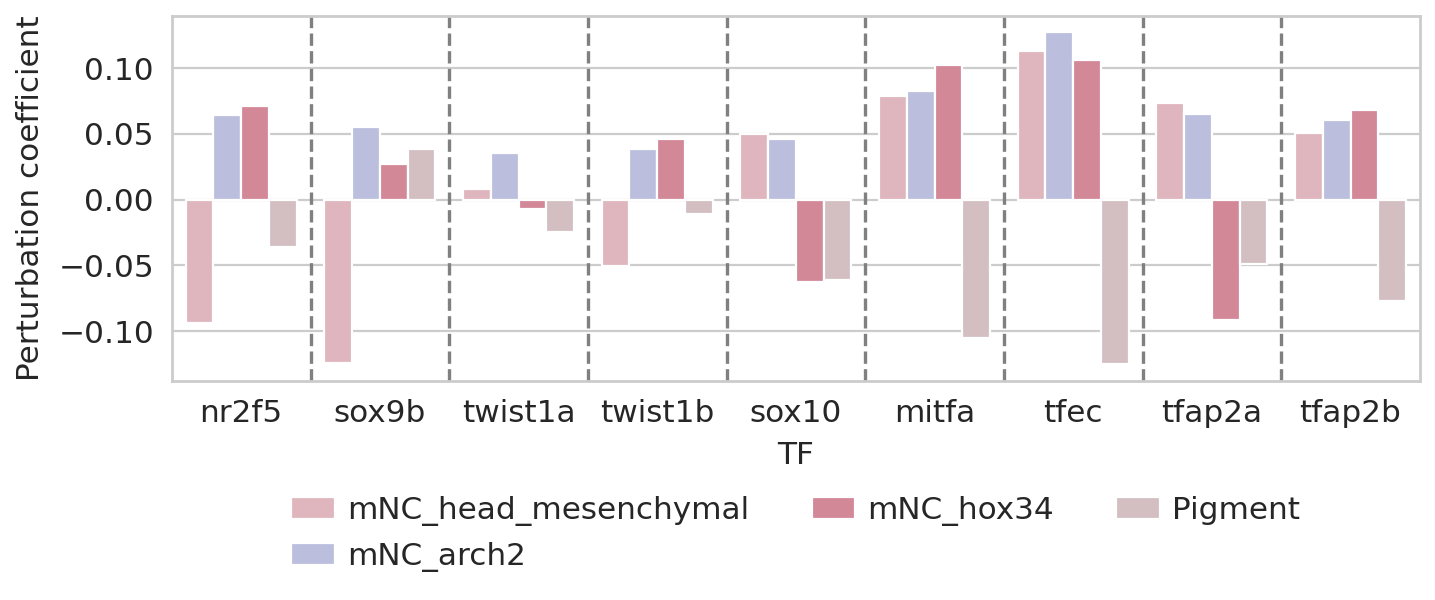

In [16]:
# Create a DataFrame for easier plotting
with mplscience.style_context():
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10,3))
    #sns.barplot(x='Terminal state', y='AUROC',data=data, hue = "Method",palette=pal,ax = ax)
    color_label = "cell_type"
    palette = dict(zip(adata.obs[color_label].cat.categories, adata.uns[f"{color_label}_colors"]))
    subset_palette = {name: color for name, color in palette.items() if name in cond2_df.columns.tolist()}

    sns.barplot(x='TF', y='Score', hue='Terminal state', data=df, ax=ax, palette=palette, dodge=True)

    # Add vertical lines to separate groups
    for i in range(len(df['TF'].unique()) - 1):
        plt.axvline(x=i + 0.5, color='gray', linestyle='--')

    # Label settings
    plt.ylabel('Perturbation coefficient', fontsize=14)
    plt.xlabel('TF', fontsize=14)
    plt.xticks(fontsize=14)  # Increase font size of x-axis tick labels
    plt.yticks(fontsize=14)  # Increase font size of y-axis tick labels

    # Customize the legend
    plt.legend(loc='lower center', fontsize = 14, bbox_to_anchor=(0.5,-0.6), ncol=3)
    if SAVE_FIGURES:
        plt.savefig(
                FIG_DIR / "zebrafish" / "perturbation" / "driver_perturbation_simulation.svg",
                format="svg",
                transparent=True,
                bbox_inches='tight'
            )
    # Show the plot
    plt.show()

## Visualize key lineage-specific TF expression pattern

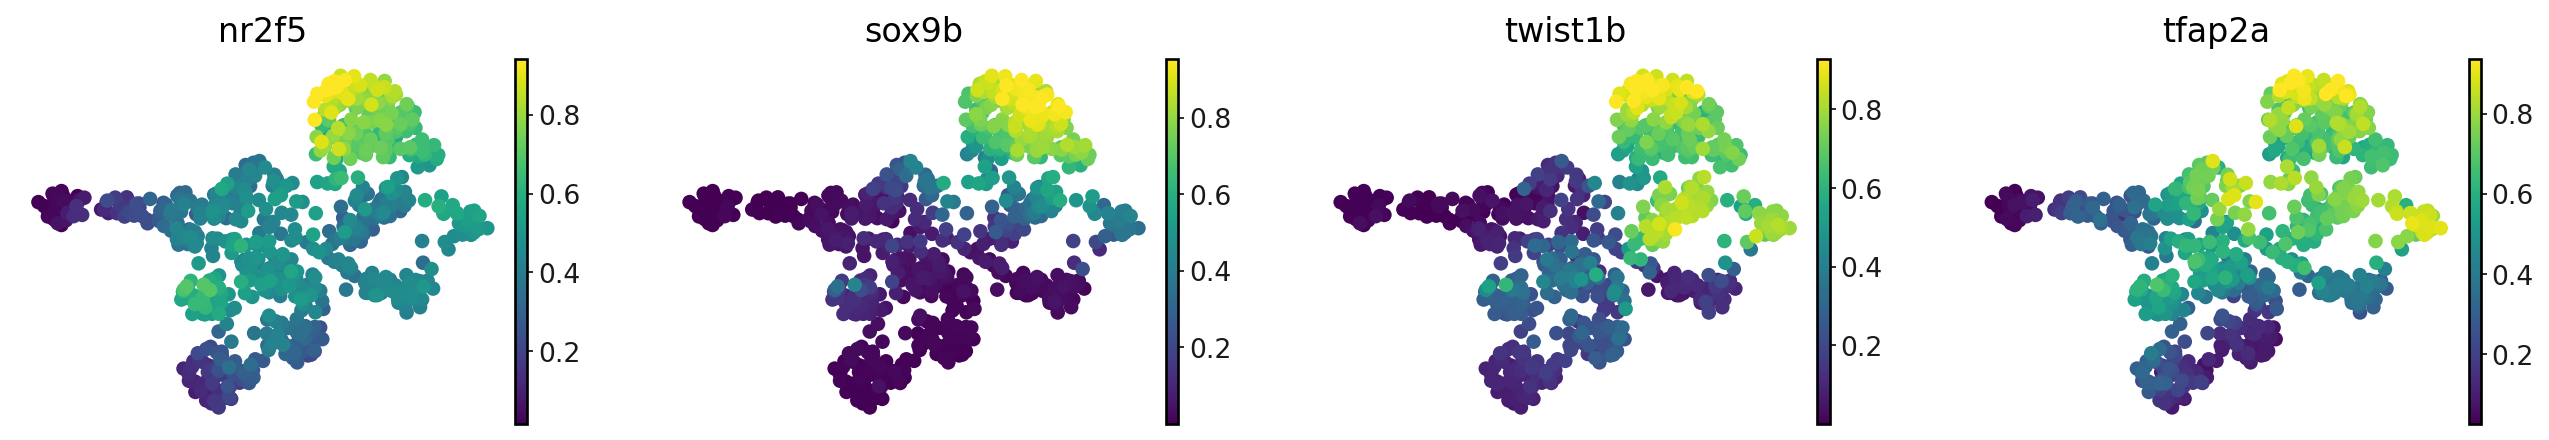

In [17]:
with mplscience.style_context():
    fig, ax = plt.subplots(1,4,figsize=(20,3))
    ax[0] = sc.pl.umap(
        adata, 
        color=["nr2f5"],
        vmin="p1",
        vmax="p99",
        frameon = False,
        legend_fontsize = 14,
        layer = "Ms",
        show = False,
        ax = ax[0]
    )

    ax[1] = sc.pl.umap(
        adata, 
        color=["sox9b"],
        vmin="p1",
        vmax="p99",
        frameon = False,
        legend_fontsize = 14,
        layer = "Ms",
        show = False,
        ax = ax[1]
    )
    
    ax[2] = sc.pl.umap(
        adata, 
        color=["twist1b"],
        vmin="p1",
        vmax="p99",
        frameon = False,
        legend_fontsize = 14,
        layer = "Ms",
        show = False,
        ax = ax[2]
    )
    
    ax[3] = sc.pl.umap(
        adata, 
        color=["tfap2a"],
        vmin="p1",
        vmax="p99",
        frameon = False,
        legend_fontsize = 14,
        layer = "Ms",
        show = False,
        ax = ax[3]
    )
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'zebrafish' / 'perturbation' / 'gene_expression.svg',
            format = 'svg',
            transparent = True,
            bbox_inches = 'tight'
        )

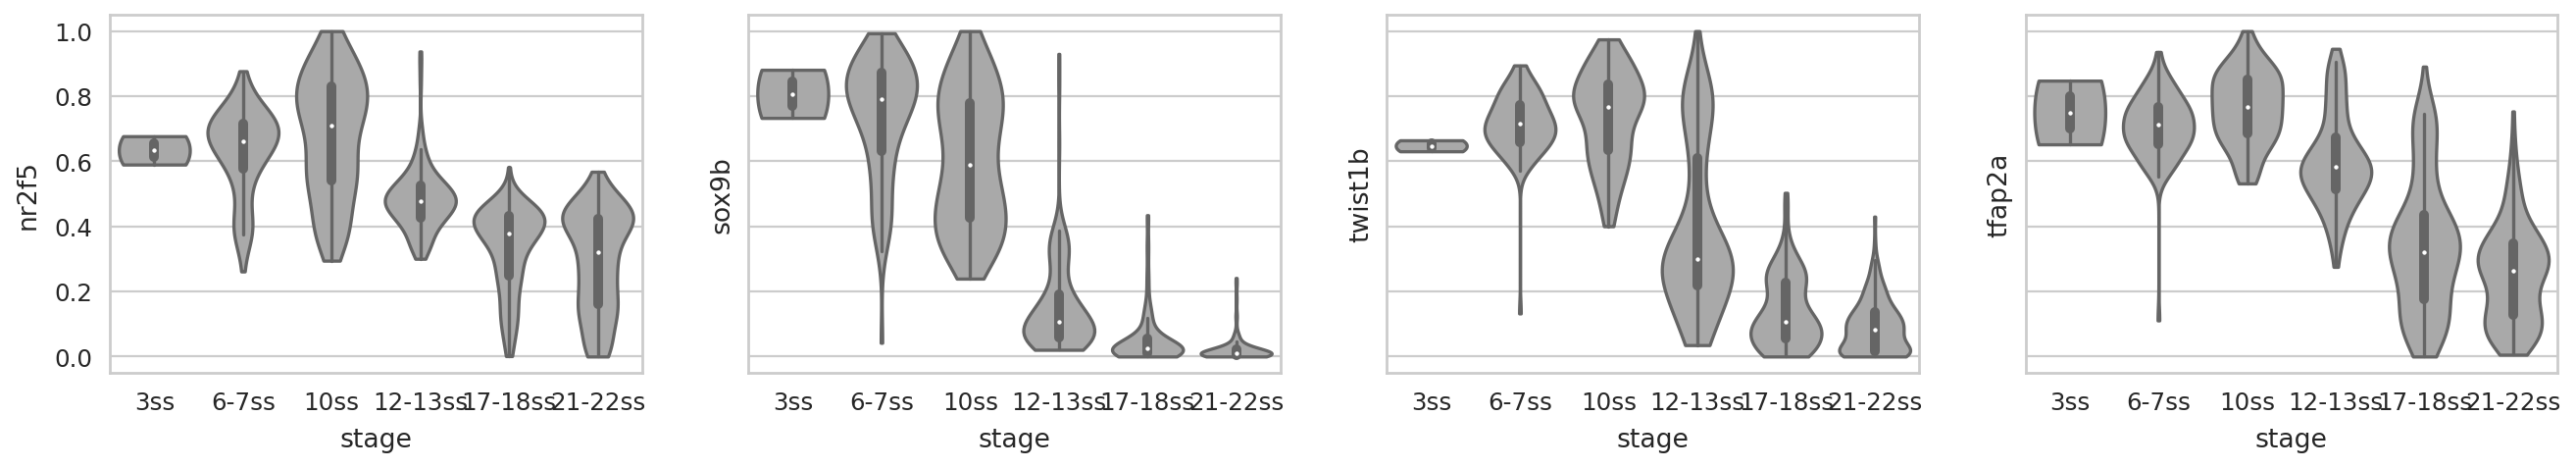

In [18]:
with mplscience.style_context():
    sns.set(style="whitegrid")
    order = ["3ss","6-7ss","10ss","12-13ss","17-18ss","21-22ss"]
    fig, ax = plt.subplots(1,4,figsize=(20,3),sharey = True)
    ax[0] = sc.pl.violin(
        adata,
        ["nr2f5"],
        groupby="stage",
        stripplot=False,  # remove the internal dots
        inner="box",  # adds a boxplot inside violins
        order = order,
        layer = "Ms",
        palette=['darkgrey'],
        show = False,
        ax = ax[0]
    )

    ax[1] = sc.pl.violin(
        adata,
        ["sox9b"],
        groupby="stage",
        stripplot=False,  # remove the internal dots
        inner="box",  # adds a boxplot inside violins
        order = order,
        layer = "Ms",
        palette=['darkgrey'],
        show = False,
        ax = ax[1]
    )
    
    ax[2] = sc.pl.violin(
        adata,
        ["twist1b"],
        groupby="stage",
        stripplot=False,  # remove the internal dots
        inner="box",  # adds a boxplot inside violins
        order = order,
        layer = "Ms",
        palette=['darkgrey'],
        show = False,
        ax = ax[2]
    )
    
    ax[3] = sc.pl.violin(
        adata,
        ["tfap2a"],
        groupby="stage",
        stripplot=False,  # remove the internal dots
        inner="box",  # adds a boxplot inside violins
        order = order,
        layer = "Ms",
        palette=['darkgrey'],
        show = False,
        ax = ax[3]
    )
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'zebrafish' / 'perturbation' / 'gene_expression_time.svg',
            format = 'svg',
            transparent = True,
            bbox_inches = 'tight'
        )

In [19]:
adata_plot = adata[adata.obs["cell_type"].isin(["NPB_nohox","mNC_hox34","Pigment","mNC_head_mesenchymal","mNC_arch2"])].copy()

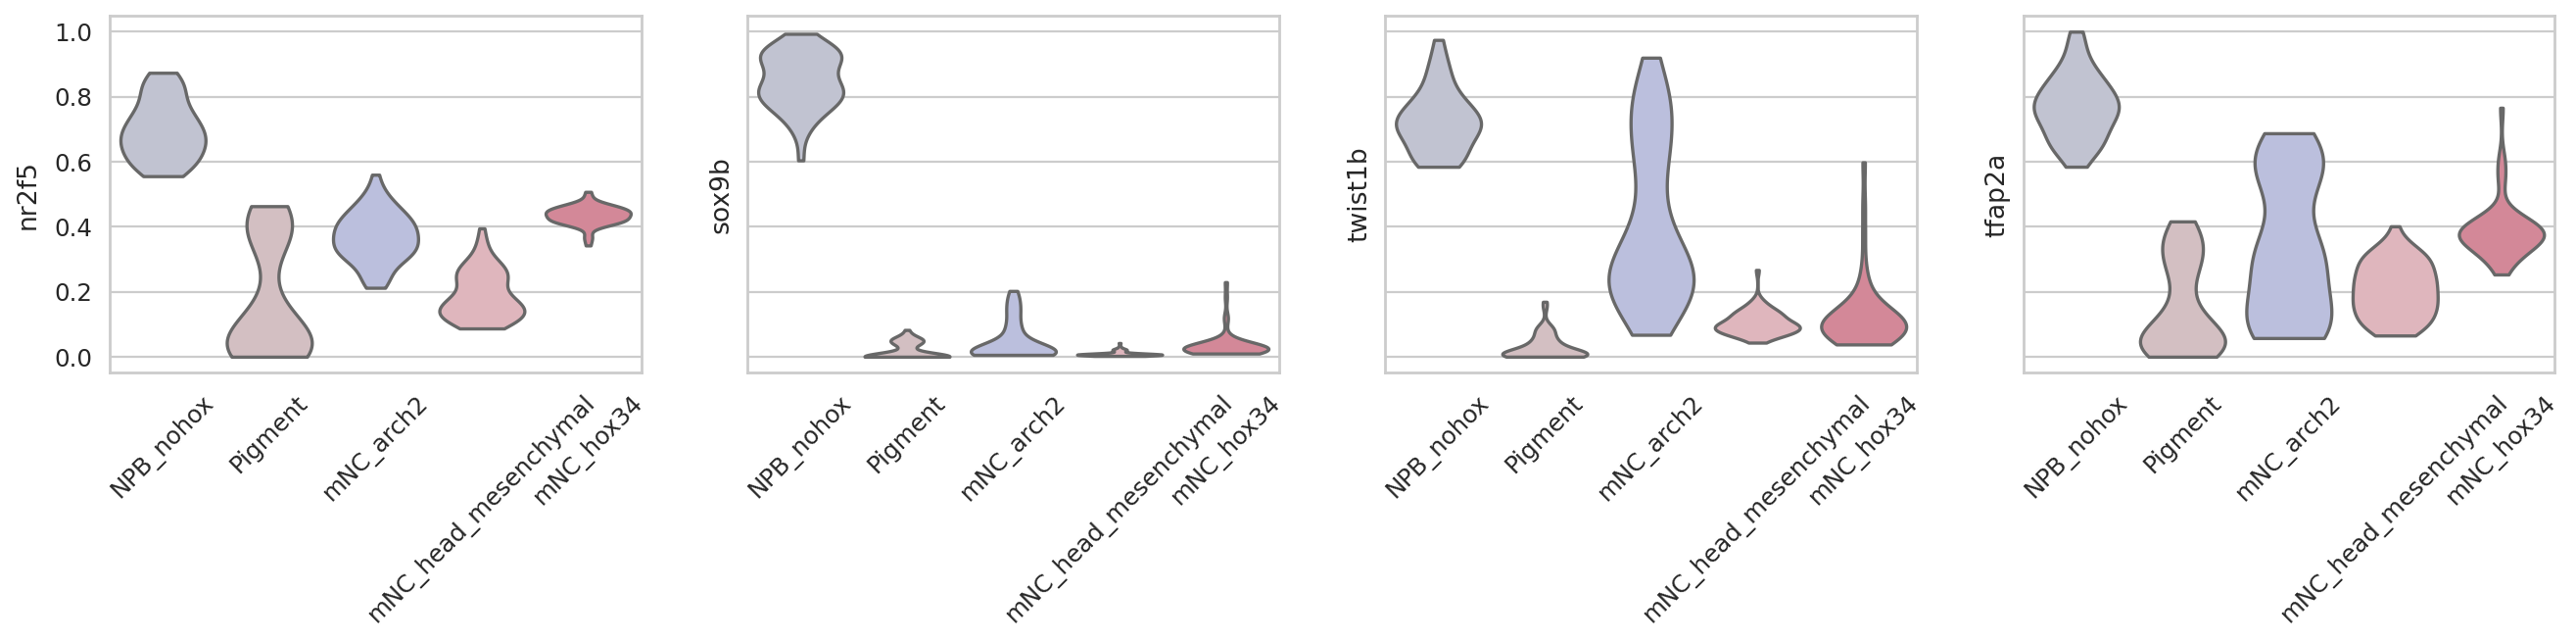

In [20]:
with mplscience.style_context():
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(1,4,figsize=(20,3),sharey = True)
    ax[0] = sc.pl.violin(
        adata_plot,
        ["nr2f5"],
        groupby="cell_type",
        stripplot=False,  # remove the internal dots
        layer = "Ms",
        use_raw = False,
        show = False,
        rotation = 45,
        ax = ax[0]
    )

    ax[1] = sc.pl.violin(
        adata_plot,
        ["sox9b"],
        groupby="cell_type",
        stripplot=False,  # remove the internal dots
        layer = "Ms",
        use_raw = False,
        show = False,
        rotation = 45,
        ax = ax[1]
    )
    
    ax[2] = sc.pl.violin(
        adata_plot,
        ["twist1b"],
        groupby="cell_type",
        stripplot=False,  # remove the internal dots
        layer = "Ms",
        use_raw = False,
        show = False,
        rotation = 45,
        ax = ax[2]
    )
    
    ax[3] = sc.pl.violin(
        adata_plot,
        ["tfap2a"],
        groupby="cell_type",
        stripplot=False,  # remove the internal dots
        layer = "Ms",
        use_raw = False,
        show = False,
        rotation = 45,
        ax = ax[3]
    )
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'zebrafish' / 'perturbation' / 'gene_expression_cell_type.svg',
            format = 'svg',
            transparent = True,
            bbox_inches = 'tight'
        )

## Using DEG test to assessing driver-lineage association

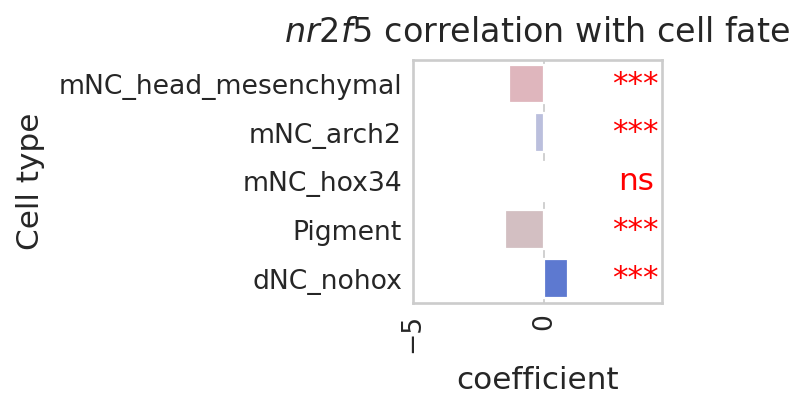

In [21]:
Gep = adata[:,"nr2f5"].layers["Ms"]
res = DEG(Gep,adata.obs["cell_type"].tolist())
res.index = res.loc[:,"cell_type"]
res.columns = ["gene","cell_type","coefficient","pvalue"]
res = res.loc[["mNC_head_mesenchymal","mNC_arch2","mNC_hox34","Pigment","dNC_nohox"],:].copy()
bar_scores(res,adata,"cell_type","nr2f5",figsize=(2, 2),min = -5,max = 4.5,loc = 3.5)

if SAVE_FIGURES:
    plt.savefig(
                FIG_DIR / 'zebrafish' / 'perturbation' / 'nr2f5_DEG.svg',
                format="svg",
                transparent=True,
                bbox_inches='tight'
            )

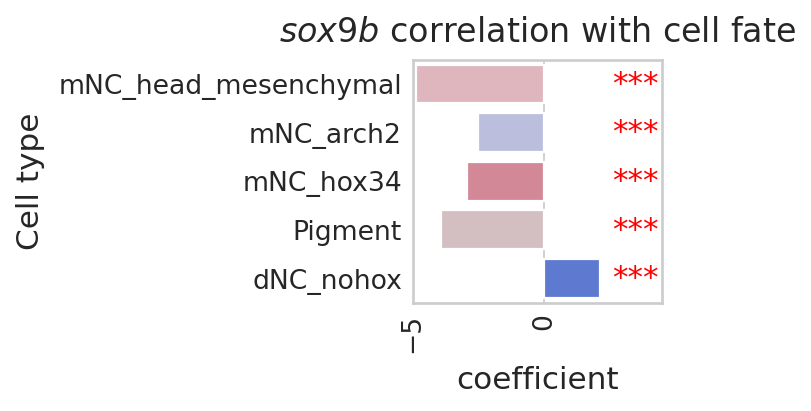

In [22]:
Gep = adata[:,"sox9b"].layers["Ms"]
res = DEG(Gep,adata.obs["cell_type"].tolist())
res.index = res.loc[:,"cell_type"]
res.columns = ["gene","cell_type","coefficient","pvalue"]
res = res.loc[["mNC_head_mesenchymal","mNC_arch2","mNC_hox34","Pigment","dNC_nohox"],:].copy()
bar_scores(res,adata,"cell_type","sox9b",figsize=(2, 2),min = -5,max = 4.5,loc = 3.5)

if SAVE_FIGURES:
    plt.savefig(
                FIG_DIR / 'zebrafish' / 'perturbation' / 'sox9b_DEG.svg',
                format="svg",
                transparent=True,
                bbox_inches='tight'
            )

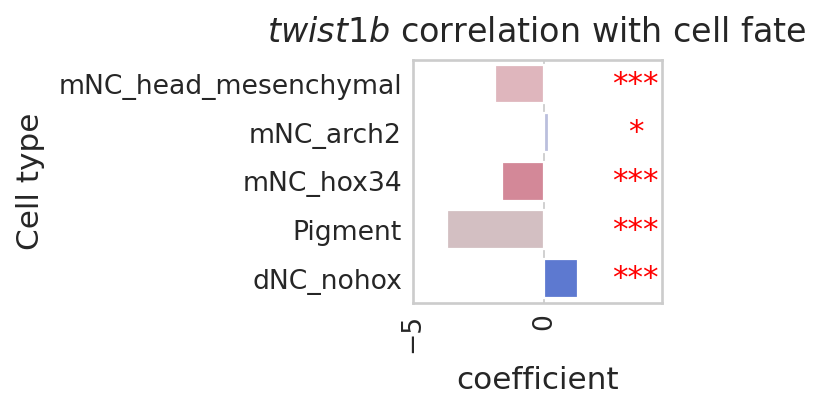

In [23]:
Gep = adata[:,"twist1b"].layers["Ms"]
res = DEG(Gep,adata.obs["cell_type"].tolist())
res.index = res.loc[:,"cell_type"]
res.columns = ["gene","cell_type","coefficient","pvalue"]
res = res.loc[["mNC_head_mesenchymal","mNC_arch2","mNC_hox34","Pigment","dNC_nohox"],:].copy()
bar_scores(res,adata,"cell_type","twist1b",figsize=(2, 2),min = -5,max = 4.5,loc = 3.5)

if SAVE_FIGURES:
    plt.savefig(
                FIG_DIR / 'zebrafish' / 'perturbation' / 'twist1b_DEG.svg',
                format="svg",
                transparent=True,
                bbox_inches='tight'
            )

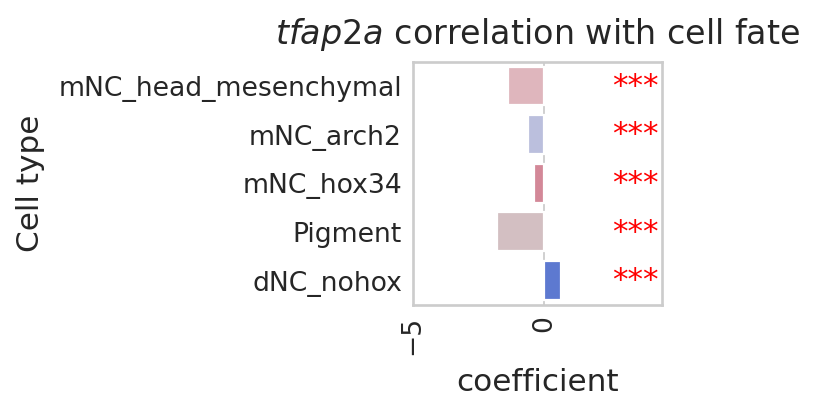

In [24]:
Gep = adata[:,"tfap2a"].layers["Ms"]
res = DEG(Gep,adata.obs["cell_type"].tolist())
res.index = res.loc[:,"cell_type"]
res.columns = ["gene","cell_type","coefficient","pvalue"]
res = res.loc[["mNC_head_mesenchymal","mNC_arch2","mNC_hox34","Pigment","dNC_nohox"],:].copy()
bar_scores(res,adata,"cell_type","tfap2a",figsize=(2, 2),min = -5,max = 4.5,loc = 3.5)

if SAVE_FIGURES:
    plt.savefig(
                FIG_DIR / 'zebrafish' / 'perturbation' / 'tfap2a_DEG.svg',
                format="svg",
                transparent=True,
                bbox_inches='tight'
            )

## Using fate probability-expression correlation to assessing driver-lineage association

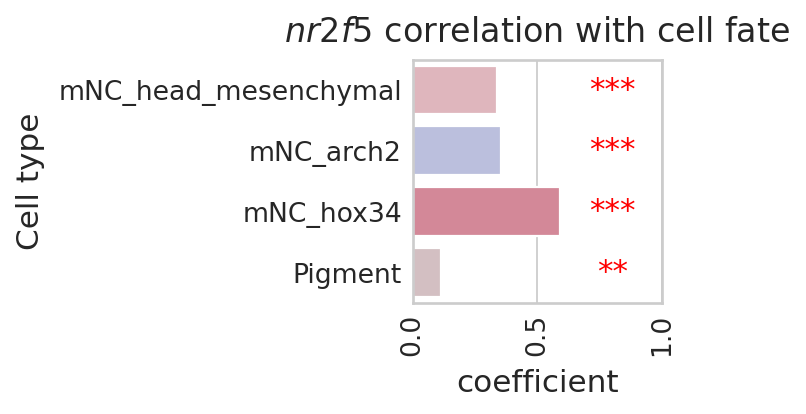

In [25]:
Gep = adata[:,"nr2f5"].layers["Ms"]
score = scipy.stats.spearmanr(pd.DataFrame(adata.obsm["lineages_fwd"]),Gep)[0][4,:4]
pvalue = []
for i in range(adata.obsm["lineages_fwd"].shape[1]):
    pvalue.append(scipy.stats.spearmanr(pd.DataFrame(adata.obsm["lineages_fwd"]).iloc[:,i],Gep)[1])

test_result = pd.DataFrame({"coefficient":score,"pvalue":pvalue})
test_result.index = adata.obsm["lineages_fwd"].names.tolist()
test_result = test_result.loc[["mNC_head_mesenchymal","mNC_arch2","mNC_hox34","Pigment"],:].copy()
bar_scores(test_result,adata,"cell_type","nr2f5",figsize=(2, 2))

if SAVE_FIGURES:
    plt.savefig(
                FIG_DIR / 'zebrafish' / 'perturbation' / 'nr2f5_cor.svg',
                format="svg",
                transparent=True,
                bbox_inches='tight'
            )

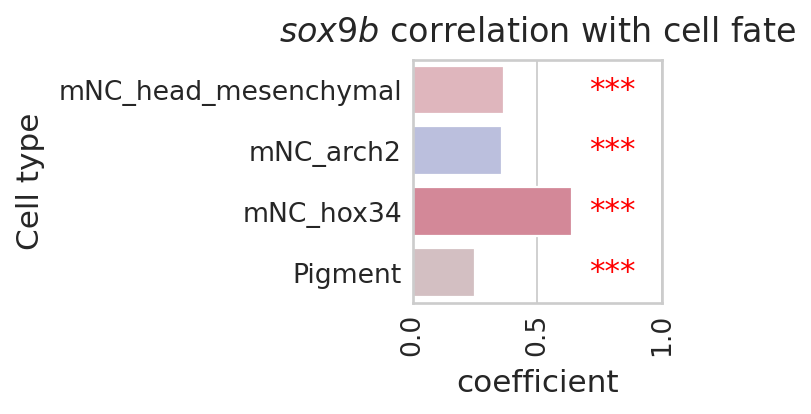

In [26]:
Gep = adata[:,"sox9b"].layers["Ms"]
score = scipy.stats.spearmanr(pd.DataFrame(adata.obsm["lineages_fwd"]),Gep)[0][4,:4]
pvalue = []
for i in range(adata.obsm["lineages_fwd"].shape[1]):
    pvalue.append(scipy.stats.spearmanr(pd.DataFrame(adata.obsm["lineages_fwd"]).iloc[:,i],Gep)[1])

test_result = pd.DataFrame({"coefficient":score,"pvalue":pvalue})
test_result.index = adata.obsm["lineages_fwd"].names.tolist()
test_result = test_result.loc[["mNC_head_mesenchymal","mNC_arch2","mNC_hox34","Pigment"],:].copy()
bar_scores(test_result,adata,"cell_type","sox9b",figsize=(2, 2))

if SAVE_FIGURES:
    plt.savefig(
                FIG_DIR / 'zebrafish' / 'perturbation' / 'sox9b_cor.svg',
                format="svg",
                transparent=True,
                bbox_inches='tight'
            )

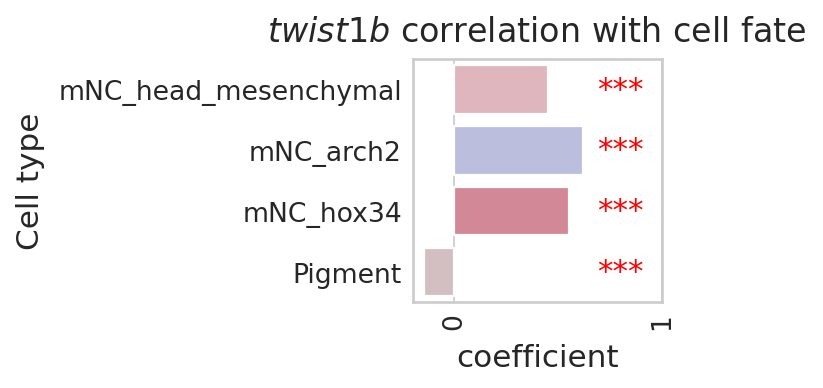

In [27]:
Gep = adata[:,"twist1b"].layers["Ms"]
score = scipy.stats.spearmanr(pd.DataFrame(adata.obsm["lineages_fwd"]),Gep)[0][4,:4]
pvalue = []
for i in range(adata.obsm["lineages_fwd"].shape[1]):
    pvalue.append(scipy.stats.spearmanr(pd.DataFrame(adata.obsm["lineages_fwd"]).iloc[:,i],Gep)[1])

test_result = pd.DataFrame({"coefficient":score,"pvalue":pvalue})
test_result.index = adata.obsm["lineages_fwd"].names.tolist()
test_result = test_result.loc[["mNC_head_mesenchymal","mNC_arch2","mNC_hox34","Pigment"],:].copy()
bar_scores(test_result,adata,"cell_type","twist1b",figsize=(2, 2),min = -0.2)

if SAVE_FIGURES:
    plt.savefig(
                FIG_DIR / 'zebrafish' / 'perturbation' / 'twist1b_cor.svg',
                format="svg",
                transparent=True,
                bbox_inches='tight'
            )

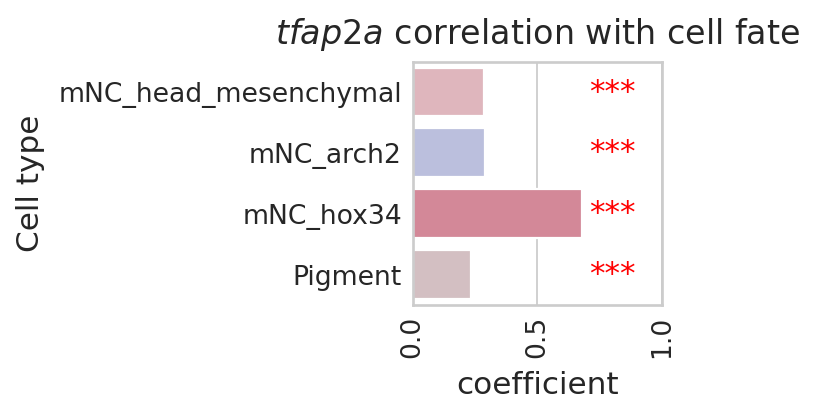

In [28]:
Gep = adata[:,"tfap2a"].layers["Ms"]
score = scipy.stats.spearmanr(pd.DataFrame(adata.obsm["lineages_fwd"]),Gep)[0][4,:4]
pvalue = []
for i in range(adata.obsm["lineages_fwd"].shape[1]):
    pvalue.append(scipy.stats.spearmanr(pd.DataFrame(adata.obsm["lineages_fwd"]).iloc[:,i],Gep)[1])

test_result = pd.DataFrame({"coefficient":score,"pvalue":pvalue})
test_result.index = adata.obsm["lineages_fwd"].names.tolist()
test_result = test_result.loc[["mNC_head_mesenchymal","mNC_arch2","mNC_hox34","Pigment"],:].copy()
bar_scores(test_result,adata,"cell_type","tfap2a",figsize=(2, 2))

if SAVE_FIGURES:
    plt.savefig(
                FIG_DIR / 'zebrafish' / 'perturbation' / 'tfap2a_cor.svg',
                format="svg",
                transparent=True,
                bbox_inches='tight'
            )

## Perturbation simulation for RegVelo

### repeat run model for 3 times

In [29]:
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()
TF_list = adata.var_names[adata.var["TF"]]

In [30]:
for nrun in range(1,3):
    print("training model...")
    REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
    reg_vae = REGVELOVI(adata,W=W.T,soft_constraint = False,regulators = TF_list)

    torch.cuda.empty_cache()
    reg_vae.train()
    
    print("save model...")
    model_name = "rgv_model_" + str(nrun)
    model = DATA_DIR / "zebrafish" / model_name
    
    reg_vae.save(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


training model...


You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1244/1500:  83%|████████▎ | 1244/1500 [09:52<02:01,  2.10it/s, loss=-2.16e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2305.010. Signaling Trainer to stop.
save model...
training model...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wangweixu/miniconda3/envs/RegVelo/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1209/1500:  81%|████████  | 1209/1500 [08:57<02:09,  2.25it/s, loss=-2.14e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2288.285. Signaling Trainer to stop.
save model...


In [31]:
## load ground truth perturbation results
perturbation = pd.read_csv("RegVelo_datasets/zebrafish/df_median_meld_likelihood.csv")

In [32]:
gene_list = ['elk3',
 'erf',
 'etv2',
 'fli1a',
 'mitfa',
 'nr2f5',
 'rarga',
 'rxraa',
 'smarcc1a',
 'tfec']
gene_list = set(gene_list).intersection(adata.var_names)
gene_list = list(gene_list)
len(gene_list)

8

In [33]:
cor_hard = []
for p in [0,1,2]:
    model_name = "rgv_model_" + str(p)
    model = DATA_DIR / "zebrafish" / model_name
    
    d = TFScanning(model,adata,8,"cell_type",terminal_states,gene_list,0)
    coef = pd.DataFrame(np.array(d['coefficient']))
    coef.index = d['TF']
    coef.columns = get_list_name(d['coefficient'][0])
    pval = pd.DataFrame(np.array(d['pvalue']))
    pval.index = d['TF']
    pval.columns = get_list_name(d['pvalue'][0])
    coef = coef.loc[gene_list,:]
    gt = perturbation.loc[[i in coef.index for i in perturbation.loc[:,"sgRNA_group"]],:].copy()
    gt = gt.loc[[i in ["Pigment_gch2_high","mNC_hox34","mNC_arch2","mNC_head_mes"] for i in gt.loc[:,"cell_anno"]],:]
    for tf in gene_list:
        gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_lochness"] = gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_lochness"] / np.mean(gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_lochness"])
    
    terminal_states = ["Pigment","mNC_hox34","mNC_arch2","mNC_head_mesenchymal"]
    coef = coef.loc[:,terminal_states]
    coef.columns = ["Pigment_gch2_high","mNC_hox34","mNC_arch2","mNC_head_mes"]
    pval = pval.loc[:,terminal_states]
    pval.columns = ["Pigment_gch2_high","mNC_hox34","mNC_arch2","mNC_head_mes"]
    pred_effect = []
    TF = []
    for i in range(gt.shape[0]):
        ts = gt.iloc[i,0]
        tf = gt.iloc[i,2]
        effect = (coef.loc[tf,ts]+1)/2
        pred_effect.append(effect)
        TF.append(tf)
    pred = pd.DataFrame({"TF":TF,"effect":pred_effect})
    cor_hard.append(scipy.stats.spearmanr(pred.iloc[:,1], gt.iloc[:,1])[0])

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done rxraa
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tfec
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done nr2f5
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done fli1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done erf
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done rarga
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done mitfa
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done elk3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done rxraa
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tfec
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done nr2f5
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done fli1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done erf
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done rarga
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done mitfa
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done elk3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done rxraa
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tfec
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done nr2f5
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done fli1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done erf
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done rarga
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done mitfa
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done elk3


In [34]:
multiple_ko = ["fli1a_elk3","mitfa_tfec","tfec_mitfa_bhlhe40","fli1a_erf_erfl3","erf_erfl3"]
multiple_ko_list = split_elements(multiple_ko)

In [35]:
## benchmark double knock-out
cor_hard_multiple = []
for p in [0,1,2]:
    model_name = "rgv_model_" + str(p)
    model = DATA_DIR / "zebrafish" / model_name
    
    d = Multiple_TFScanning(model,adata,8,"cell_type",terminal_states,multiple_ko_list,0)
    coef = pd.DataFrame(np.array(d['coefficient']))
    coef.index = d['TF']
    coef.columns = get_list_name(d['coefficient'][0])
    pval = pd.DataFrame(np.array(d['pvalue']))
    pval.index = d['TF']
    pval.columns = get_list_name(d['pvalue'][0])
    gt = perturbation.copy()
    gt = gt.loc[[i in coef.index for i in gt.loc[:,"sgRNA_group"]],:]
    gt = gt.loc[[i in ["Pigment_gch2_high","mNC_hox34","mNC_arch2","mNC_head_mes"] for i in gt.loc[:,"cell_anno"]],:]
    for tf in coef.index:
        gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_lochness"] = gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_lochness"] / np.mean(gt.loc[[i in tf for i in gt.loc[:,"sgRNA_group"]],"median_lochness"])
    
    terminal_states = ["Pigment","mNC_hox34","mNC_arch2","mNC_head_mesenchymal"]
    coef = coef.loc[:,terminal_states]
    coef.columns = ["Pigment_gch2_high","mNC_hox34","mNC_arch2","mNC_head_mes"]
    pval = pval.loc[:,terminal_states]
    pval.columns = ["Pigment_gch2_high","mNC_hox34","mNC_arch2","mNC_head_mes"]
    pred_effect = []
    TF = []
    for i in range(gt.shape[0]):
        ts = gt.iloc[i,0]
        tf = gt.iloc[i,2]
        effect = (coef.loc[tf,ts]+1)/2
        pred_effect.append(effect)
        TF.append(tf)
    pred = pd.DataFrame({"TF":TF,"effect":pred_effect})
    cor_hard_multiple.append(scipy.stats.spearmanr(pred.iloc[:,1], gt.iloc[:,1])[0])

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

['fli1a', 'elk3']
Done fli1a_elk3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

['mitfa', 'tfec']
Done mitfa_tfec
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

['tfec', 'mitfa', 'bhlhe40']
Done tfec_mitfa_bhlhe40
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

['fli1a', 'erf', 'erfl3']
Done fli1a_erf_erfl3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

['erf', 'erfl3']
Done erf_erfl3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

['fli1a', 'elk3']
Done fli1a_elk3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

['mitfa', 'tfec']
Done mitfa_tfec
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

['tfec', 'mitfa', 'bhlhe40']
Done tfec_mitfa_bhlhe40
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

['fli1a', 'erf', 'erfl3']
Done fli1a_erf_erfl3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

['erf', 'erfl3']
Done erf_erfl3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

['fli1a', 'elk3']
Done fli1a_elk3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

['mitfa', 'tfec']
Done mitfa_tfec
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

['tfec', 'mitfa', 'bhlhe40']
Done tfec_mitfa_bhlhe40
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

['fli1a', 'erf', 'erfl3']
Done fli1a_erf_erfl3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

['erf', 'erfl3']
Done erf_erfl3


In [36]:
dat = pd.DataFrame({"spearman_correlation": cor_hard[0:3] + [0.12170087976539588] + [0.08431085043988269] + [0.032654572533862496],
                    "method":["RegVelo"]*3 + ["dynamo(KO)"] + ["dynamo(perturbation)"] + ["celloracle"]})
dat2 = pd.DataFrame({"spearman_correlation": cor_hard_multiple + [0.19849624060150375] + [0.14586466165413534] + [0.09326815251530708],
                    "method":["RegVelo"]*3 + ["dynamo(KO)"] + ["dynamo(perturbation)"] + ["celloracle"]})
dat["Experimental class"] = "Single TF knock-out"
dat2["Experimental class"] = "Multiple TF knock-out"
df = pd.concat([dat, dat2], axis=0)

In [37]:
random_colors = [(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451)]

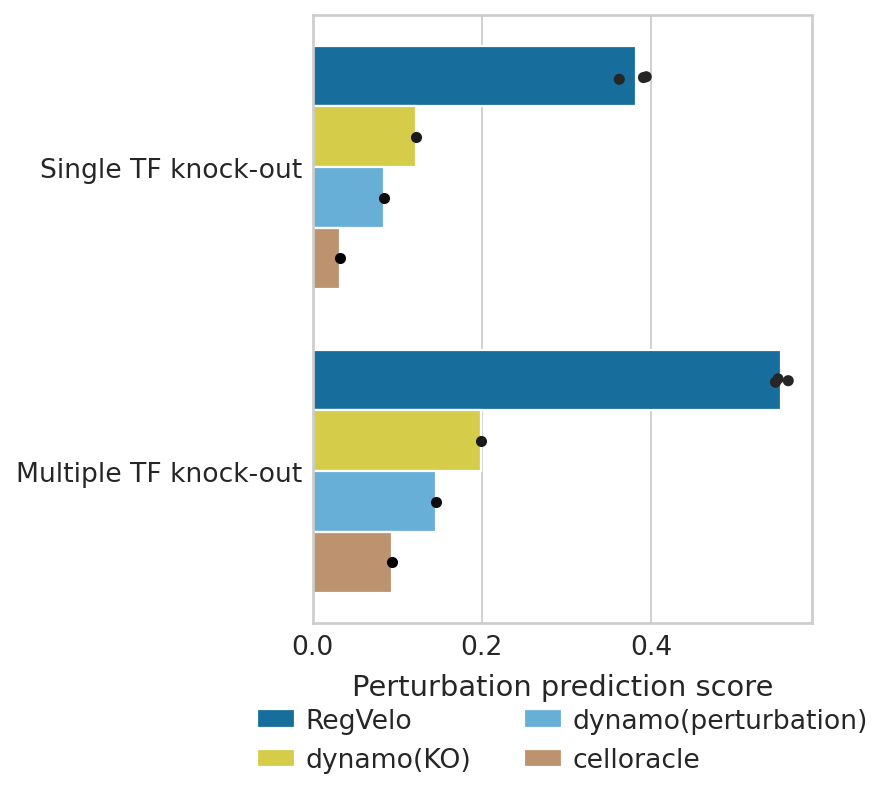

In [38]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(4, 5))

    # Plot the barplot without error bars
    sns.barplot(data=df, y="Experimental class", x="spearman_correlation", hue="method", palette=random_colors, ax=ax, ci=None)

    # Add jittered dots
    sns.stripplot(data=df, y="Experimental class", x="spearman_correlation", hue="method", dodge=True, color="black", ax=ax, jitter=True)

    # Remove the duplicate legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[4:(4+len(random_colors))], labels[4:(4+len(random_colors))], bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=2)

    # Customize labels and other settings
    ax.set(ylabel='', xlabel='Perturbation prediction score')
    ax.set_xlabel(xlabel='Perturbation prediction score', fontsize=13)
    
    if SAVE_FIGURES:
        plt.savefig(FIG_DIR / 'zebrafish' / 'perturbation' / 'barplot_joint_knockout.svg',
                    format="svg",
                    transparent=True,
                    bbox_inches='tight')

## Save perturbation results

In [39]:
for nrun in range(3):
    model_name = "rgv_model_" + str(nrun)
    coef_name = "coef_" + str(nrun) + "_update"
    pval_name = "pval_" + str(nrun) + "_update"
    
    model = DATA_DIR / "zebrafish" / model_name
    coef_save = DATA_DIR / "zebrafish" / "perturbation" / coef_name
    pval_save = DATA_DIR / "zebrafish" / "perturbation" / pval_name
    
    perturb_screening = TFScanning(model,adata,8,"cell_type",terminal_states,TF_list,0)
    coef = pd.DataFrame(np.array(perturb_screening['coefficient']))
    coef.index = perturb_screening['TF']
    coef.columns = get_list_name(perturb_screening['coefficient'][0])

    pval = pd.DataFrame(np.array(perturb_screening['pvalue']))
    pval.index = perturb_screening['TF']
    pval.columns = get_list_name(perturb_screening['pvalue'][0])

    rows_with_nan = coef.isna().any(axis=1)
    # Set all values in those rows to NaN
    coef.loc[rows_with_nan, :] = np.nan
    pval.loc[rows_with_nan, :] = np.nan

    coef.to_csv(coef_save)
    pval.to_csv(pval_save)

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done alx4a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done arntl1b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done bach2b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done bhlhe40
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done bhlhe41
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done dlx1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done ebf1b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done ebf3a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done egr1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done egr2b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done egr3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done egr4
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done elf1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done elk3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done erf
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done erfl3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done ets1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done etv5b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done fli1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done fosab
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done fosl1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done fosl2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done her9
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hnf1ba
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hnf1bb
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxa11b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxa2b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxa4a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxa9a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxa9b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxb10a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxb1b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxb5b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxb9a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxc11b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxc3a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxc9a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxd11a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxd12a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done jdp2b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done jun
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done junba
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done mitfa
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done msx1b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done msx3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done mycb
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done nfe2l2a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done nr2f2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done nr2f5
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done nr2f6b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done nr4a2b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done otx2b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done pbx1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done pknox2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done rarga
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done rxraa
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done snai1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done sox10
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done sox6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done sox9b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tead1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tead1b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tead3a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tead3b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tfap2a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tfap2b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tfap2e
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tfec
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done twist1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done twist1b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done zeb1b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done zic2a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_0
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done zic2b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done alx4a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done arntl1b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done bach2b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done bhlhe40
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done bhlhe41
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done dlx1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done ebf1b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done ebf3a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done egr1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done egr2b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done egr3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done egr4
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done elf1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done elk3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done erf
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done erfl3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done ets1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done etv5b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done fli1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done fosab
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done fosl1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done fosl2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done her9
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hnf1ba
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hnf1bb
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxa11b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxa2b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxa4a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxa9a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxa9b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxb10a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxb1b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxb5b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxb9a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxc11b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxc3a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxc9a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxd11a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxd12a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done jdp2b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done jun
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done junba
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done mitfa
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done msx1b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done msx3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done mycb
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done nfe2l2a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done nr2f2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done nr2f5
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done nr2f6b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done nr4a2b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done otx2b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done pbx1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done pknox2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done rarga
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done rxraa
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done snai1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done sox10
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done sox6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done sox9b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tead1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tead1b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tead3a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tead3b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tfap2a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tfap2b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tfap2e
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tfec
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done twist1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done twist1b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done zeb1b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done zic2a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_1
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done zic2b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done alx4a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done arntl1b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done bach2b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done bhlhe40
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done bhlhe41
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done dlx1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done ebf1b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done ebf3a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done egr1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done egr2b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done egr3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done egr4
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done elf1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done elk3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done erf
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done erfl3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done ets1
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done etv5b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done fli1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done fosab
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done fosl1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done fosl2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done her9
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hnf1ba
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hnf1bb
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxa11b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxa2b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxa4a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxa9a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxa9b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxb10a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxb1b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxb5b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxb9a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxc11b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxc3a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxc9a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxd11a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done hoxd12a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done jdp2b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done jun
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done junba
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done mitfa
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done msx1b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done msx3
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done mycb
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done nfe2l2a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done nr2f2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done nr2f5
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done nr2f6b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done nr4a2b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done otx2b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done pbx1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done pknox2
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done rarga
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done rxraa
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done snai1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done sox10
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done sox6
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done sox9b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tead1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tead1b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tead3a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tead3b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tfap2a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tfap2b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tfap2e
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tfec
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done twist1a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done twist1b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done zeb1b
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done zic2a
INFO     File                                                                                                      
         /mnt/data1/weixu+DL/RegVelo/RegVelo_local/RegVelo_local/RegVelo_reproducibility/data/zebrafish/rgv_model_2
         /model.pt already downloaded                                                                              


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done zic2b


## Compare driver ranking performance

In [40]:
df = g_raw.compute_lineage_drivers(
    cluster_key="cell_type"
)

In [41]:
fate_prob = pd.DataFrame(g_raw.adata.obsm['lineages_fwd'],columns = g_raw.adata.obsm['lineages_fwd'].names.tolist())

In [42]:
GeneActivity = pd.read_csv("RegVelo_datasets/zebrafish/GeneActivity.csv",index_col = 0)

In [43]:
gene_symbol = [i.replace("_pos","").replace("_neg","") for i in GeneActivity.index.tolist()]

In [44]:
ind = [i in adata.var_names[adata.var["TF"]] for i in gene_symbol]

In [45]:
GeneActivity = GeneActivity.iloc[ind,:]
gene_symbol = [i.replace("_pos","").replace("_neg","") for i in GeneActivity.index.tolist()]

In [46]:
df_a = pd.DataFrame(columns=df.columns.tolist())
for i in fate_prob.columns.tolist():
    cor = []
    pval = []
    for g in GeneActivity.index.tolist():
        res = scipy.stats.pearsonr(GeneActivity.loc[g,:],fate_prob.loc[:,i])
        cor.append(res[0])
        pval.append(res[1])
    df_a[i+"_corr"] = cor
    df_a[i+"_pval"] = pval

In [47]:
df_a.index = GeneActivity.index.tolist()

In [48]:
## predict known drivers
driver_head_mes = ["nr2f5","sox9b","twist1a","twist1b"]
label = [1 if i in driver_head_mes else 0 for i in gene_symbol]

In [49]:
fpr, tpr, thresholds = metrics.roc_curve(label, df_a["mNC_head_mesenchymal_corr"], pos_label=1)
GA_head_mes = list()
GA_head_mes.append(metrics.auc(fpr, tpr))

In [50]:
label = [1 if i in driver_head_mes else 0 for i in df.index.tolist()]
fpr, tpr, thresholds = metrics.roc_curve(label, df["mNC_head_mesenchymal_corr"], pos_label=1)
Gene_head_mes = list()
Gene_head_mes.append(metrics.auc(fpr, tpr))

In [51]:
coef = pd.read_csv(DATA_DIR / 'zebrafish' / 'perturbation' / 'coef_1_update',index_col = 0)
coef = -coef

label = [1 if i in driver_head_mes else 0 for i in coef.index.tolist()]
fpr, tpr, thresholds = metrics.roc_curve(label, coef["mNC_head_mesenchymal"], pos_label=1)
rgv_head_mes = list()
rgv_head_mes.append(metrics.auc(fpr, tpr))

In [52]:
## predict known drivers
driver_pigment = ["sox10","mitfa","tfec","tfap2a","tfap2b"]
label = [1 if i in driver_pigment else 0 for i in gene_symbol]

In [53]:
fpr, tpr, thresholds = metrics.roc_curve(label, df_a["Pigment_corr"], pos_label=1)
GA_pigment = list()
GA_pigment.append(metrics.auc(fpr, tpr))

In [54]:
label = [1 if i in driver_pigment else 0 for i in df.index.tolist()]
fpr, tpr, thresholds = metrics.roc_curve(label, df["Pigment_corr"], pos_label=1)
Gene_pigment = list()
Gene_pigment.append(metrics.auc(fpr, tpr))

In [55]:
label = [1 if i in driver_pigment else 0 for i in coef.index.tolist()]
fpr, tpr, thresholds = metrics.roc_curve(label, coef["Pigment"], pos_label=1)
rgv_pigment = list()
rgv_pigment.append(metrics.auc(fpr, tpr))

In [56]:
## barplot to show the performance comparsion
coef = pd.read_csv(DATA_DIR / 'zebrafish' / 'perturbation' / 'coef_0_update',index_col = 0)
coef = -coef
label = [1 if i in driver_head_mes else 0 for i in coef.index.tolist()]
fpr, tpr, thresholds = metrics.roc_curve(label, coef["mNC_head_mesenchymal"], pos_label=1)
rgv_head_mes.append(metrics.auc(fpr, tpr))

coef = pd.read_csv(DATA_DIR / 'zebrafish' / 'perturbation' / 'coef_0_update',index_col = 0)
coef = -coef
label = [1 if i in driver_pigment else 0 for i in coef.index.tolist()]
fpr, tpr, thresholds = metrics.roc_curve(label, coef["Pigment"], pos_label=1)
rgv_pigment.append(metrics.auc(fpr, tpr))

In [57]:
## barplot to show the performance comparsion
coef = pd.read_csv(DATA_DIR / 'zebrafish' / 'perturbation' / 'coef_2_update',index_col = 0)
coef = -coef
label = [1 if i in driver_head_mes else 0 for i in coef.index.tolist()]
fpr, tpr, thresholds = metrics.roc_curve(label, coef["mNC_head_mesenchymal"], pos_label=1)
rgv_head_mes.append(metrics.auc(fpr, tpr))

coef = pd.read_csv(DATA_DIR / 'zebrafish' / 'perturbation' / 'coef_2_update',index_col = 0)
coef = -coef
label = [1 if i in driver_pigment else 0 for i in coef.index.tolist()]
fpr, tpr, thresholds = metrics.roc_curve(label, coef["Pigment"], pos_label=1)
rgv_pigment.append(metrics.auc(fpr, tpr))

In [58]:
## visualize comparison
dat = pd.DataFrame({"AUROC": rgv_head_mes + GA_head_mes + Gene_head_mes,
                    "method":["RegVelo(PS)"]*3 + ["CR(GA)"] + ["CR(GEX)"]})
dat2 = pd.DataFrame({"AUROC": rgv_pigment + GA_pigment + Gene_pigment,
                    "method":["RegVelo(PS)"]*3 + ["CR(GA)"] + ["CR(GEX)"]})
dat["Lineage"] = "mNC head mesenchymal"
dat2["Lineage"] = "Pigment"
df = pd.concat([dat, dat2], axis=0)

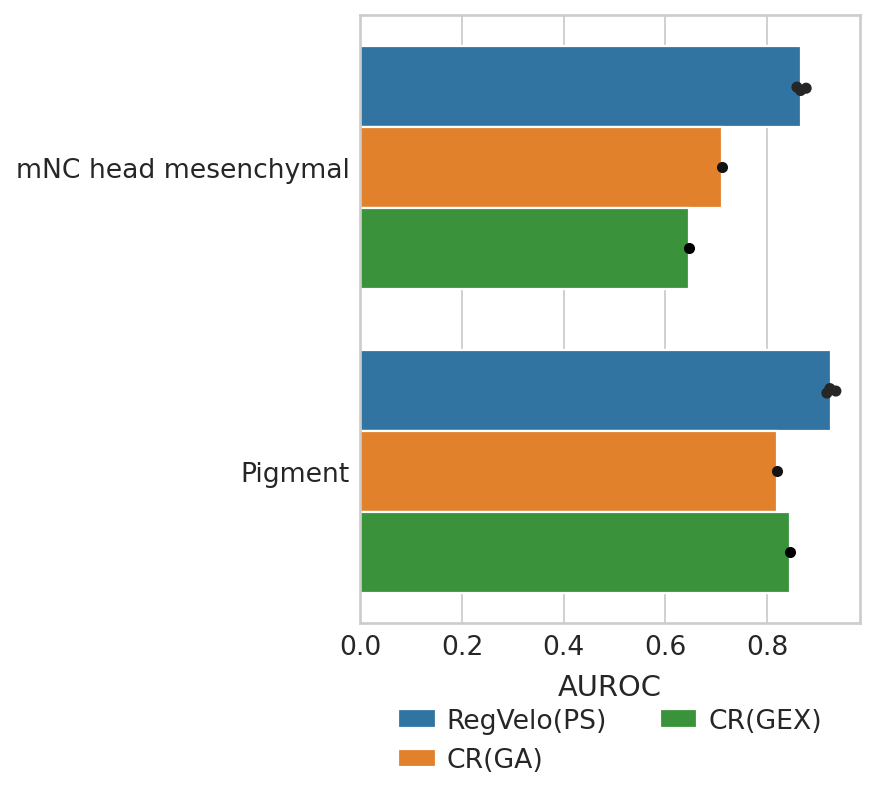

In [59]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(4, 5))

    # Plot the barplot without error bars
    sns.barplot(data=df, y="Lineage", x="AUROC", hue="method", ax=ax, ci=None)

    # Add jittered dots
    sns.stripplot(data=df, y="Lineage", x="AUROC", hue="method", dodge=True, color="black", ax=ax, jitter=True)

    # Remove the duplicate legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[3:6], labels[3:6], bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=2)

    # Customize labels and other settings
    ax.set(ylabel='', xlabel='AUROC')
    ax.set_xlabel(xlabel='AUROC', fontsize=13)
    
    if SAVE_FIGURES:
        plt.savefig(FIG_DIR / 'zebrafish' / 'perturbation' / 'AUROC_ranking.svg',
                    format="svg",
                    transparent=True,
                    bbox_inches='tight')